LangChain data chunking example

By using Langchain's recursive character text splitter to chunk text. Source files are large PDFs loaded using PyPDFLoader.

This also complements the Chunking large documents for vector search solutions article in the Azure AI Search documentation.

In [ ]:
%pip install --quiet -r requirements.txt

Load .env file

In [2]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv() # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
search_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_embedding_deployment_id = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"]
recursivetextsplitter_searchindex = os.environ["AZURE_SEARCH_LANGCHAIN_RECURSIVETEXTSPLITTER_INDEX"]

search_credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
azure_openai_key = os.environ["AZURE_OPENAI_KEY"] if len(os.environ["AZURE_OPENAI_KEY"]) > 0 else None


Setup sample resources for embedding chunks

In [3]:
from openai import AzureOpenAI
from azure.identity import get_bearer_token_provider

azure_openai_client = None
if azure_openai_key:
    azure_openai_client = AzureOpenAI(
        api_key=azure_openai_key, 
        api_version="2023-05-15",
        azure_deployment=azure_openai_embedding_deployment_id,
        azure_endpoint=azure_openai_endpoint)
else:
    azure_openai_client = AzureOpenAI(
        azure_ad_token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
        api_version="2023-05-15",
        azure_deployment=azure_openai_embedding_deployment_id,
        azure_endpoint=azure_openai_endpoint)

Setup sample resources for recursive text splitter chunking


In [4]:
from azure.search.documents.indexes import SearchIndexClient
from lib.common import (
    create_search_index,
)

search_index_client = SearchIndexClient(endpoint=search_endpoint, credential=search_credential)
rts_searchindex = create_search_index(
    recursivetextsplitter_searchindex,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key
)
search_index_client.create_or_update_index(rts_searchindex)

print("Created recursive text splitter index")

Created recursive text splitter index


Load PDF

In [6]:
from langchain_community.document_loaders import PyPDFLoader
import os

loader = PyPDFLoader(os.path.join("..","data", "documents","마산항인보이스샘플.pdf"))
pages = loader.load()

Ignoring wrong pointing object 2 0 (offset 0)
Ignoring wrong pointing object 56 0 (offset 0)
Ignoring wrong pointing object 60 0 (offset 0)
Ignoring wrong pointing object 65 0 (offset 0)
Ignoring wrong pointing object 70 0 (offset 0)
Ignoring wrong pointing object 100 0 (offset 0)


Generate histogram of token and character lengths per page


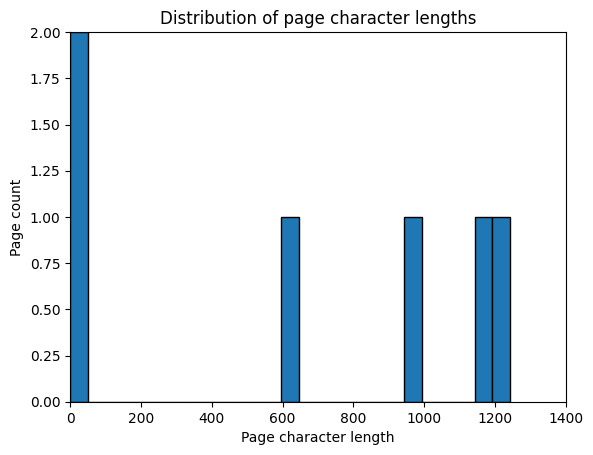

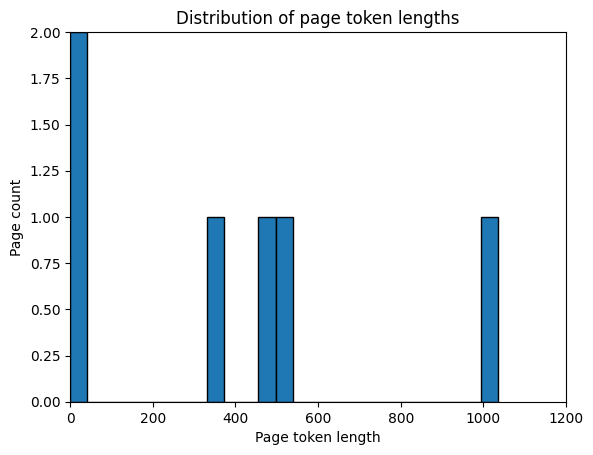

In [7]:
%matplotlib inline
from lib.common import plot_chunk_histogram, get_token_length

page_content = [page.page_content for page in pages]

plot_chunk_histogram(
    chunks=page_content,
    length_fn=len,
    title="Distribution of page character lengths",
    xlabel="Page character length",
    ylabel="Page count")
plot_chunk_histogram(
    chunks=page_content,
    length_fn=get_token_length,
    title="Distribution of page token lengths",
    xlabel="Page token length",
    ylabel="Page count")

Chunk PDF using Recursive text splitter
We use the output of the above historgrams to guide us into selecting a 600 token chunk length with a 150 token overlap.

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from lib.common import get_encoding_name

# from_tiktoken_encoder enables use to split on tokens rather than characters
recursive_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
   encoding_name=get_encoding_name(),
   chunk_size=600, 
   chunk_overlap=125
)

recursive_text_splitter_chunks = recursive_text_splitter.split_documents(pages)

Generate histogram of chunk character and token lengths


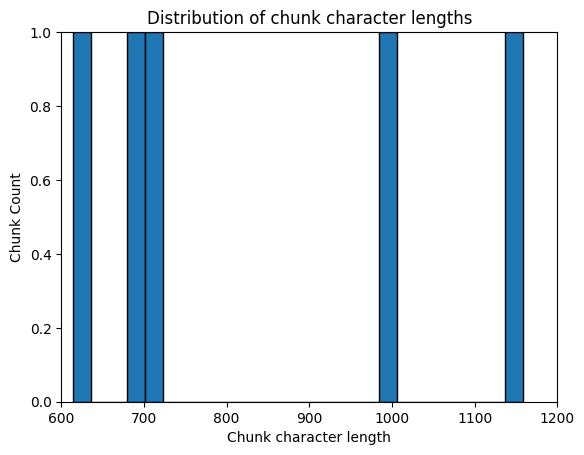

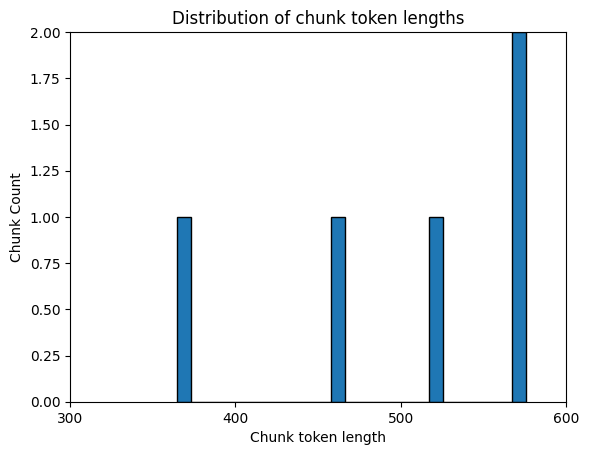

In [9]:
chunk_content = [chunk.page_content for chunk in recursive_text_splitter_chunks]

plot_chunk_histogram(
    chunks=chunk_content,
    length_fn=len,
    title="Distribution of chunk character lengths",
    xlabel="Chunk character length")
plot_chunk_histogram(
    chunks=chunk_content,
    length_fn=get_token_length,
    title="Distribution of chunk token lengths",
    xlabel="Chunk token length")

Embed Recursive text splitter chunks


In [10]:
recursive_text_splitter_embeddings = azure_openai_client.embeddings.create(input=chunk_content, model=azure_openai_embedding_deployment_id)
recursive_text_splitter_embeddings = [result.embedding for result in recursive_text_splitter_embeddings.data]

Upload chunks to search index


In [ ]:
recursive_search_client = search_index_client.get_search_client(recursivetextsplitter_searchindex)

docs = [
    {
        "parent_id": "0",
        "chunk_id": f"invoice{i}",
        "chunk": chunk.page_content,
        "title": "invoice.pdf",
        "vector": recursive_text_splitter_embeddings[i]
    }
    for i, chunk in enumerate(recursive_text_splitter_chunks)
]

recursive_search_client.upload_documents(docs)

print("Uploaded chunks and embeddings for recursive text splitter")